In [1]:
%env SM_FRAMEWORK=tf.keras

env: SM_FRAMEWORK=tf.keras


In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
import cv2
import segmentation_models as sm

2023-09-05 15:10:18.881313: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-09-05 15:10:18.913690: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-05 15:10:19.388375: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Segmentation Models: using `tf.keras` framework.


In [3]:
import mlflow
mlflow.set_tracking_uri("databricks")
mlflow.set_experiment("/Users/danimar301@student.polsl.pl/Extraterrestial-Rock-Segmentation")

<Experiment: artifact_location='dbfs:/databricks/mlflow-tracking/1048085717579938', creation_time=1668775123782, experiment_id='1048085717579938', last_update_time=1673965167011, lifecycle_stage='active', name='/Users/danimar301@student.polsl.pl/Extraterrestial-Rock-Segmentation', tags={'mlflow.experiment.sourceName': '/Users/danimar301@student.polsl.pl/Extraterrestial-Rock-Segmentation',
 'mlflow.experimentType': 'MLFLOW_EXPERIMENT',
 'mlflow.ownerEmail': 'danimar301@student.polsl.pl',
 'mlflow.ownerId': '7796760964070965'}>

In [4]:
# Prepare paths of input images and target segmentation masks
# RockA is a simple data set with a few rocks
# RockB is more challanging -- according to description on github
input_dir_rockA = "../datasets with noise/rock-a"
target_dir_rockA = "../MarsData/MarsData-main/Data/Rock-A/label/Rock-A mask"

input_dir_rockB = "../datasets with noise/rock-b"
target_dir_rockB = "../MarsData/MarsData-main/Data/Rock-B/label/Rock-B mask"

img_size = (320,320)
# img_size = (336, 336)

rockA_input_img_paths = sorted([
    os.path.join(input_dir_rockA, fname)
    for fname in os.listdir(input_dir_rockA)
    if fname.endswith(".png")
])

#Sorting mask names in target folder
rockA_target_img_paths = sorted([
    os.path.join(target_dir_rockA, fname)
    for fname in os.listdir(target_dir_rockA)
    if fname.endswith(".png") and not fname.startswith(".")
])

rockB_input_img_paths = sorted([
    os.path.join(input_dir_rockB, fname)
    for fname in os.listdir(input_dir_rockB)
    if fname.endswith(".png")
])

#Sorting mask names in target folder
rockB_target_img_paths = sorted([
    os.path.join(target_dir_rockB, fname)
    for fname in os.listdir(target_dir_rockB)
    if fname.endswith(".png") and not fname.startswith(".")
])

print("Number of Rock-A input samples:", len(rockA_input_img_paths))
print("Number of Rock-A target samples:", len(rockA_target_img_paths))

for input_path, target_path in zip(rockA_input_img_paths[:10], rockA_target_img_paths[:10]):
    print(input_path, "|", target_path)
    
print("Number of Rock-B input samples:", len(rockB_input_img_paths))
print("Number of Rock-B target samples:", len(rockB_target_img_paths))

for input_path, target_path in zip(rockB_input_img_paths[:10], rockB_target_img_paths[:10]):
    print(input_path, "|", target_path)

Number of Rock-A input samples: 201
Number of Rock-A target samples: 201
../datasets with noise/rock-a/1516_1516ML0077220050604247E01_DXXX_aug_1.png | ../MarsData/MarsData-main/Data/Rock-A/label/Rock-A mask/1516_1516ML0077220050604247E01_DXXX.png
../datasets with noise/rock-a/1516_1516MR0077180000204657E01_DXXX_aug_1.png | ../MarsData/MarsData-main/Data/Rock-A/label/Rock-A mask/1516_1516MR0077180000204657E01_DXXX.png
../datasets with noise/rock-a/1518_1518ML0077330000604252E01_DXXX_aug_1.png | ../MarsData/MarsData-main/Data/Rock-A/label/Rock-A mask/1518_1518ML0077330000604252E01_DXXX.png
../datasets with noise/rock-a/1518_1518ML0077330050604257E01_DXXX_aug_1.png | ../MarsData/MarsData-main/Data/Rock-A/label/Rock-A mask/1518_1518ML0077330050604257E01_DXXX.png
../datasets with noise/rock-a/1518_1518ML0077330060604258E02_DXXX_aug_1.png | ../MarsData/MarsData-main/Data/Rock-A/label/Rock-A mask/1518_1518ML0077330060604258E02_DXXX.png
../datasets with noise/rock-a/1518_1518MR0077310000204672

In [5]:
# auxiliary utility functions
def extract_mask_from_ground(ground_img, lower_color_threshold):
    (R, G, B) = cv2.split(ground_img)
    
    # Values are clipped as it is a binary classification problem
    R_ranged = np.clip(cv2.inRange(R, lower_color_threshold, 255), 0, 1) 
    G_ranged = np.clip(cv2.inRange(G, lower_color_threshold, 255), 0, 1) 
    B_ranged = np.clip(cv2.inRange(B, lower_color_threshold, 255), 0, 1)

    merged = cv2.merge([B_ranged, G_ranged, R_ranged])
    merged = np.expand_dims(merged, 3)
    merged = np.amax(merged, axis=2)
    return merged

# The threshold value determines how many small rocks are visible, higher threshold means less blue rocks
def load_ground(path, color_threshold):
    img_ground = cv2.imread(path)
    img_ground_rgb = cv2.cvtColor(img_ground, cv2.COLOR_BGR2RGB)
    img_ground_rgb = cv2.resize(img_ground_rgb, img_size[::-1])
    return extract_mask_from_ground(img_ground_rgb, color_threshold)

Input image: 


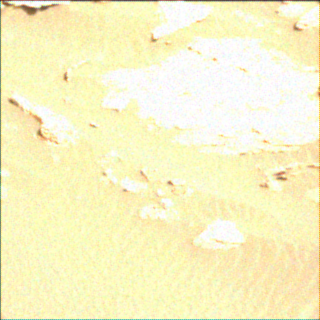

Target image: 


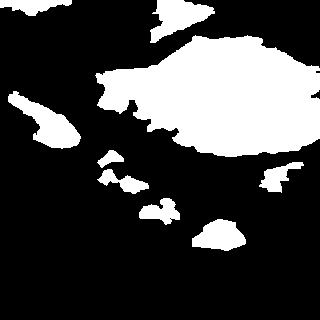

(320, 320, 1)
[0 1]


In [6]:
from IPython.display import Image, display
from tensorflow.keras.preprocessing.image import load_img
import PIL
from PIL import ImageOps

image_index = 2

# Display input image 
print("Input image: ")
display(Image(filename=rockA_input_img_paths[image_index], width = 320, height = 320))

print("Target image: ")
img_ground = load_ground(rockA_target_img_paths[image_index], 1)
display(tf.keras.preprocessing.image.array_to_img(img_ground))

print(img_ground.shape)
print(np.unique(img_ground))

Input image: 


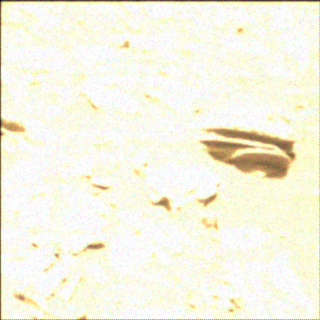

Target image: 


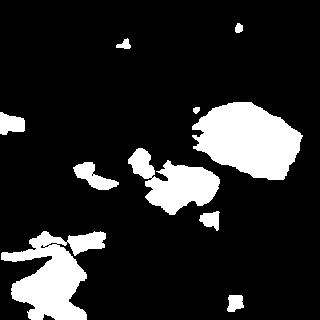

(320, 320, 1)
[0 1]


In [7]:
from IPython.display import Image, display
from tensorflow.keras.preprocessing.image import load_img
import PIL
from PIL import ImageOps

image_index = 2

# Display input image 
print("Input image: ")
display(Image(filename=rockB_input_img_paths[image_index], width = 320, height = 320))

print("Target image: ")
img_ground = load_ground(rockB_target_img_paths[image_index], 1)
display(tf.keras.preprocessing.image.array_to_img(img_ground))

print(img_ground.shape)
print(np.unique(img_ground))

In [8]:
from skimage import color
class MartianRocks(keras.utils.Sequence):
    def __init__(self, batch_size, img_size, input_img_paths, target_img_paths, color_threshold):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_paths = input_img_paths
        self.target_img_paths = target_img_paths
        self.color_threshold = color_threshold
        
    def __len__(self):
        return len(self.target_img_paths) // self.batch_size
    
    def __getitem__(self, idx):
        # Returns tuple (input, target) corresponding to batch idx
        i = idx * self.batch_size
        batch_input_img_paths = self.input_img_paths[i : i + self.batch_size]
        batch_target_img_paths = self.target_img_paths[i : i + self.batch_size]
        
        # 3 Dimensional input images
        x = np.zeros((self.batch_size,) + self.img_size + (3,), dtype="float32")
        for j, path in enumerate(batch_input_img_paths):
            img = load_img(path, target_size = self.img_size)
            x[j] = img
                
        # 1 Dimensional target mask
        y = np.zeros((self.batch_size,) + self.img_size + (1,), dtype="uint8")
        for j, path in enumerate(batch_target_img_paths):
            # load ground imahe
            y[j] = load_ground(path, self.color_threshold)
                
        return x, y
    
class MartianRocksGreyscaled(MartianRocks):
    
    def __getitem__(self, idx):
        # Returns tuple (input, target) corresponding to batch idx
        i = idx * self.batch_size
        batch_input_img_paths = self.input_img_paths[i : i + self.batch_size]
        batch_target_img_paths = self.target_img_paths[i : i + self.batch_size]
        
        # 3 Dimensional input images
        x = np.zeros((self.batch_size,) + self.img_size + (3,), dtype="float32")
        for j, path in enumerate(batch_input_img_paths):
            img = load_img(path, target_size = self.img_size)
            img = color.rgb2gray(img)
            img =  np.repeat(img[..., np.newaxis], 3, -1)
            x[j] = img
                
        # 1 Dimensional target mask
        y = np.zeros((self.batch_size,) + self.img_size + (1,), dtype="uint8")
        for j, path in enumerate(batch_target_img_paths):
            # load ground imahe
            y[j] = load_ground(path, self.color_threshold)
                
        return x, y


<class 'tuple'>
[0 1]
<class 'numpy.uint8'>


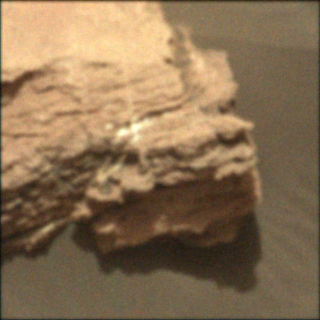

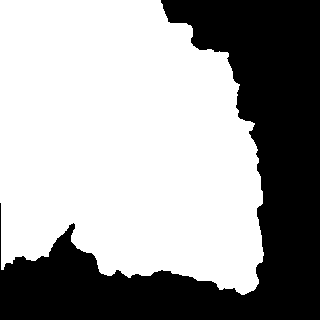

<class 'tuple'>
[0 1]
<class 'numpy.uint8'>


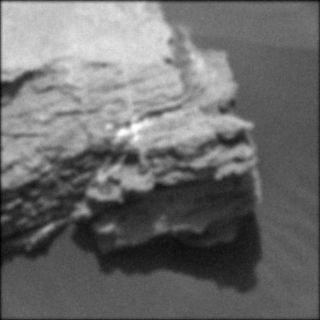

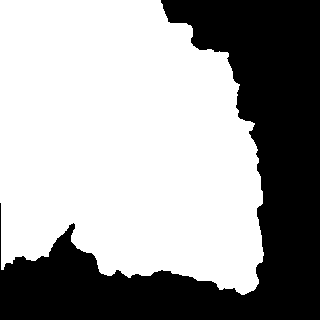

In [9]:
loader = MartianRocks(16, img_size, rockA_input_img_paths[:250], 
            rockA_target_img_paths[:250], color_threshold = 1)

print(type(loader.__getitem__(3)))
print(np.unique(loader.__getitem__(1)[1][1]))
print(type(loader.__getitem__(1)[1][3][0][0][0]))
batch = loader.__getitem__(2)
display(tf.keras.preprocessing.image.array_to_img(batch[0][1]))
display(tf.keras.preprocessing.image.array_to_img(batch[1][1]))

loaderGreyscaled = MartianRocksGreyscaled(
            16, img_size, rockA_input_img_paths[:250], 
            rockA_target_img_paths[:250], color_threshold = 1)

print(type(loaderGreyscaled.__getitem__(3)))
print(np.unique(loaderGreyscaled.__getitem__(1)[1][1]))
print(type(loaderGreyscaled.__getitem__(1)[1][3][0][0][0]))
batch = loaderGreyscaled.__getitem__(2)
display(tf.keras.preprocessing.image.array_to_img(batch[0][1]))
display(tf.keras.preprocessing.image.array_to_img(batch[1][1]))

In [10]:
rockA_generator = MartianRocks(16, img_size, rockA_input_img_paths, 
            rockA_target_img_paths, color_threshold = 1)

rockB_generator = MartianRocks(16, img_size, rockB_input_img_paths, 
            rockB_target_img_paths, color_threshold = 1)

In [56]:
from segmentation_models.losses  import bce_jaccard_loss
from segmentation_models.metrics import IOUScore

run_id = 0

# This line downloads models from mlflow artifacts
temp_dir = mlflow.artifacts.download_artifacts(
    'dbfs:/databricks/mlflow-tracking/1048085717579938/ebbdc78331674d99b2aaf8b5a279e5a9/artifacts/model')
print(temp_dir)
model = keras.models.load_model(temp_dir + '/data/model', compile=False)
model.summary()

2023/09/05 15:27:00 INFO mlflow.store.artifact.artifact_repo: The progress bar can be disabled by setting the environment variable MLFLOW_ENABLE_ARTIFACTS_PROGRESS_BAR to false


/tmp/tmp_o535e8y/model
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 320, 320, 3)]        0         []                            
                                                                                                  
 Conv1_pad (ZeroPadding2D)   (None, 321, 321, 3)          0         ['input_1[0][0]']             
                                                                                                  
 Conv1 (Conv2D)              (None, 160, 160, 32)         864       ['Conv1_pad[0][0]']           
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 160, 160, 32)         128       ['Conv1[0][0]']               
 on)                                                                   

In [ ]:
# tf.keras.utils.plot_model(model, show_shapes=True)
import visualkeras
from tensorflow.python.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, ZeroPadding2D
from PIL import ImageFont

font = ImageFont.truetype('/usr/share/fonts/truetype/roboto-slab/RobotoSlab-Regular.ttf', 500, encoding="unic")  # using comic sans is strictly prohibited!
# visualkeras.layered_view(model, type_ignore=[ZeroPadding2D, Dropout, Flatten])
visualkeras.layered_view(model, scale_xy=1.5, scale_z=1, max_z=1, legend=True, draw_volume=True, type_ignore=[ZeroPadding2D, Dropout, Flatten], spacing=2)
# visualkeras.layered_view(model, scale_xy=3, legend=True)
tf.keras.utils.plot_model(model, to_file="unet_seresnet.png", show_shapes=True)

In [57]:
from  mlflow.tracking import MlflowClient
client = MlflowClient()

converter = tf.lite.TFLiteConverter.from_saved_model(temp_dir + '/data/model') # path to the SavedModel directory
converter.optimizations = [tf.lite.Optimize.DEFAULT]

# with mlflow.start_run(run_name="LinkNet with MobileNetV2, compressed") as run:
tflite_model = converter.convert()

# run_id = run.info.run_id


# Save the model.
# with open('linknet_mobilenet_compressed.tflite', 'wb') as f:
#   f.write(tflite_model)

# client.log_artifact(run_id, 'linknet_mobilenetv2_compressed.tflite')

interpreter = tf.lite.Interpreter(model_content=tflite_model)
interpreter.allocate_tensors()

2023-09-05 15:27:54.529237: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
2023-09-05 15:27:54.529259: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2023-09-05 15:27:54.529410: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp_o535e8y/model/data/model
2023-09-05 15:27:54.545833: I tensorflow/cc/saved_model/reader.cc:91] Reading meta graph with tags { serve }
2023-09-05 15:27:54.545855: I tensorflow/cc/saved_model/reader.cc:132] Reading SavedModel debug info (if present) from: /tmp/tmp_o535e8y/model/data/model
2023-09-05 15:27:54.604755: I tensorflow/cc/saved_model/loader.cc:231] Restoring SavedModel bundle.
2023-09-05 15:27:55.273234: I tensorflow/cc/saved_model/loader.cc:215] Running initialization op on SavedModel bundle at path: /tmp/tmp_o535e8y/model/data/model
2023-09-05 15:27:55.422768: I tensorflow/cc/saved_model/loader.cc:314] SavedModel load fo

In [58]:
from tqdm import tqdm
def compressed_predict(interpreter, input_paths):
    input_index = interpreter.get_input_details()[0]["index"]
    output_index = interpreter.get_output_details()[0]["index"]
    # Run predictions on ever y image in the "test" dataset.
    predictions = []
    for i, test_image_path in tqdm(enumerate(input_paths)):
        # Pre-processing: add batch dimension and convert to float32 to match with
        # the model's input data format.
        test_image = load_img(test_image_path, target_size = img_size)
        # print(type(test_image))
        # test_image = test_image.astype(np.float32)
        test_image = np.expand_dims(test_image, axis=0).astype(np.float32)
        # print(test_image.shape)
        interpreter.set_tensor(input_index, test_image)

        # Run inference.
        interpreter.invoke()

        # Post-processing: remove batch dimension and find the digit with highest
        # probability.
        pred = interpreter.get_tensor(output_index)
        pred = pred.squeeze(axis=0)
        predictions.append(pred)


    return predictions

rockA_preds_compressed = compressed_predict(interpreter, rockA_input_img_paths)
rockB_preds_compressed = compressed_predict(interpreter, rockB_input_img_paths)

201it [00:29,  6.79it/s]
204it [00:30,  6.78it/s]


In [59]:
# Generate predictions for rockA set
rockA_preds = model.predict(rockA_generator)

# Generate predictions for greyscaled rockA set
# rockA_greyscaled_preds = model.predict(rockA_grayscaled_generator)

# Generate predictions for rockB set
rockB_preds = model.predict(rockB_generator)

# Generate predictions for greyscaled rockB set
# rockB_greyscaled_preds = model.predict(rockB_grayscaled_generator)

12/12 [==============================] - 2s 124ms/step


In [15]:
from skimage import color
# Display results for validation image with index i

def get_mask(i, preds):
    #Quick utilization to display a model's prediction

    mask = np.argmax(preds[i], axis=2)
    mask = np.expand_dims(mask, axis=-1)
    mask = mask - 1 
    mask = np.clip(mask, 0, 1)
    # img = PIL.ImageOps.autocontrast(tf.keras.preprocessing.image.array_to_img(mask))
    return mask

def show_results(index, input_paths, target_paths, predictions):
    # Load input image
    # print(input_paths[index])
    # print(target_paths[index])
    original = cv2.imread(input_paths[index])
    display(tf.keras.preprocessing.image.array_to_img(original))
    original = cv2.resize(original, img_size)

    #Load ground-truth target mask
    target = load_ground(target_paths[index], 1)

    target_img = tf.keras.preprocessing.image.array_to_img(target)

    # Display mask predicted by model
    pred_mask = get_mask(index, predictions)

    pred_mask_img = PIL.ImageOps.autocontrast(tf.keras.preprocessing.image.array_to_img(pred_mask))

    # Applay segmentation mask onto real image
    final_predicted = color.label2rgb(np.asarray(pred_mask_img), original, bg_label=0)
    final_target = color.label2rgb(np.asarray(target_img), original, bg_label=0)

    # Stack segmentation masks on real images
    final = np.hstack((final_target, final_predicted))

    # Stack only masks
    pred_mask = np.hstack((target, pred_mask))
    display(PIL.ImageOps.autocontrast(tf.keras.preprocessing.image.array_to_img(pred_mask))) 

    display(tf.keras.preprocessing.image.array_to_img(final))
    
def show_results_with_compressed(index, input_paths, target_paths, predictions, predictions_compressed):
    # Load input image
    # print(input_paths[index])
    # print(target_paths[index])
    original = cv2.imread(input_paths[index])
    display(tf.keras.preprocessing.image.array_to_img(original))
    original = cv2.resize(original, img_size)

      #Load ground-truth target mask
    target = load_ground(target_paths[index], 1)

    target_img = tf.keras.preprocessing.image.array_to_img(target)

      # display(tf.keras.preprocessing.image.array_to_img(target))


      # Display mask predicted by model
    pred_mask = get_mask(index, predictions)
    pred_mask_compressed = get_mask(index, predictions_compressed)

    pred_mask_img = PIL.ImageOps.autocontrast(tf.keras.preprocessing.image.array_to_img(pred_mask))
    pred_mask_cprsd_img = PIL.ImageOps.autocontrast(tf.keras.preprocessing.image.array_to_img(pred_mask_compressed))

      # Applay segmentation mask onto real image
    final_predicted = color.label2rgb(np.asarray(pred_mask_img), original, bg_label=0, colors = ['red', 'green', 'blue'])
    final_prediction_cmprsd = color.label2rgb(np.asarray(pred_mask_cprsd_img), original, bg_label=0, colors = ['red', 'green', 'blue'] )
    final_target = color.label2rgb(np.asarray(target_img), original, bg_label=0, colors = ['red', 'green', 'blue'])


    print('Target: ')
    display(tf.keras.preprocessing.image.array_to_img(final_target))

    print('Prediction: ')
    display(tf.keras.preprocessing.image.array_to_img(final_predicted))

    print('Compressed prediction: ')
    display(tf.keras.preprocessing.image.array_to_img(final_prediction_cmprsd))

    

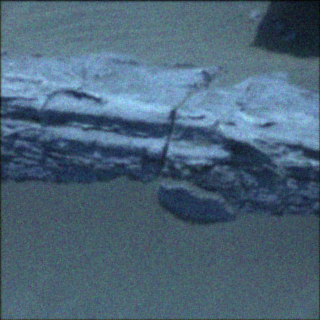

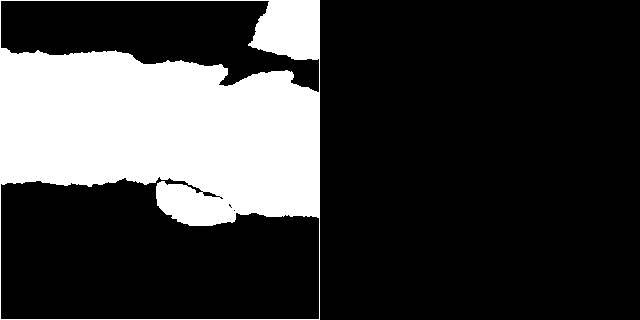

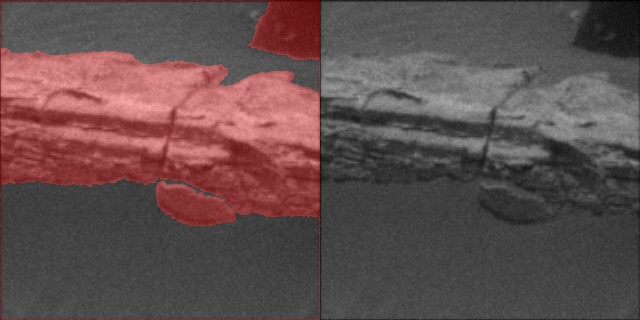

In [16]:
i = 9

show_results(i, rockA_input_img_paths, rockA_target_img_paths, rockA_preds)

In [17]:
# Utility function for evaluating models performance with any given metric
import keras.backend as K

# Calculate dice coefficent for one input array
def dice_coef(y_true, y_pred):
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    intersection = np.sum(y_true_f * y_pred_f)
    smooth = 0.0001
    return (2. * intersection + smooth) / (np.sum(y_true_f) + np.sum(y_pred_f) + smooth)

# Calculate average dice loss for every label
def dice_coef_multilabel(y_true, y_pred, numLabels):
    dice = [0, 0]
    result = 0
    average = 0
    for index in range(numLabels):
        result = dice_coef(y_true[:,:,index], y_pred[:,:,index]) # @Todo: Zbierać dice score dla każdej klasy
        # print("Dice score for class {}: {}".format(index, result))
        dice[index] += result
        average += result
    return (dice, average/numLabels) # taking average

#@todo: make function for evaluating dice loss
def calculate_dice_loss(preds, target_paths, color_threshold=1):
    result = [0,0]
    average = []
    for i, mask in enumerate(preds):
        mask = np.argmax(mask, axis=2)
        mask = np.expand_dims(mask, axis=-1)
        mask = mask - 1
        mask = np.clip(mask, 0, 1)
        target = cv2.imread(target_paths[i])
        target = cv2.cvtColor(target, cv2.COLOR_BGR2RGB)

        target = cv2.resize(target, img_size[::-1])
        target = extract_mask_from_ground(target, color_threshold)

      #One hot encoding so the Dice coefficent works
        mask = tf.one_hot(mask, 2)
        mask = np.squeeze(mask, axis=2)
        target = tf.one_hot(target, 2)
        target = np.squeeze(target, axis=2)
#         print(mask.shape)
#         print(target.shape)
        dice_coef_tuple = dice_coef_multilabel(target, mask, 2)
        average.append(dice_coef_tuple[1])
        for i, value in enumerate(dice_coef_tuple[0]):
            result[i] += value

    for i, value in enumerate(result):
        print("Dice score for class {}: {}".format(i, value/len(preds)))
    return average

# Calculate metrics for all model predictions, returns a list 
def evaluate_model(preds, target_paths_here, metric, color_threshold=1):
    result = []
    metric.reset_states()
    for i, mask in enumerate(preds):
        mask = np.argmax(mask, axis=2)
        mask = np.expand_dims(mask, axis=-1)
        mask = mask - 1
        mask = np.clip(mask, 0, 1)
#         print(np.unique(mask))
        target = cv2.imread(target_paths_here[i])
        target = cv2.cvtColor(target, cv2.COLOR_BGR2RGB)

        target = cv2.resize(target, img_size[::-1])
        target = extract_mask_from_ground(target, color_threshold)

        metric.update_state(target, mask)
        result.append(metric.result().numpy())
    return result



In [18]:
def double_metrics_calculation(preds, preds_compressed, target, color_threshold=1):
  # Define metrics
    meanIoU = tf.keras.metrics.MeanIoU(num_classes=2)
    accuracy_metric = tf.keras.metrics.Accuracy()
    rmse_metric = tf.keras.metrics.RootMeanSquaredError()

    metrics = []
    metrics_comporessed = []

    # Calculate metrics for test set
    dice = calculate_dice_loss(preds,  target, color_threshold)
    iou = evaluate_model(preds,  target, meanIoU, color_threshold)
    accuracy =  evaluate_model(preds,  target, accuracy_metric, color_threshold)
    rmse = evaluate_model(preds,  target, rmse_metric, color_threshold)

    metrics = [accuracy, dice, iou, rmse]

    # Calculate metrics for test set
    dice_compressed = calculate_dice_loss(preds_compressed,  target, color_threshold)
    iou_compressed = evaluate_model(preds_compressed,  target, meanIoU, color_threshold)
    accuracy_compressed =  evaluate_model(preds_compressed,  target, accuracy_metric, color_threshold)
    rmse_compressed = evaluate_model(preds_compressed,  target, rmse_metric, color_threshold)

    metrics_compressed = [accuracy_compressed, dice_compressed, iou_compressed, rmse_compressed]

    return (metrics, metrics_compressed)

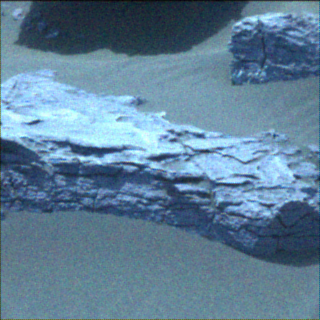

Target: 


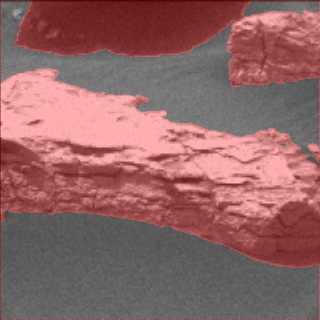

Prediction: 


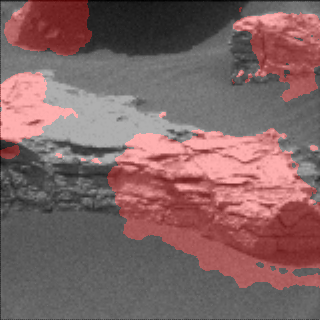

Compressed prediction: 


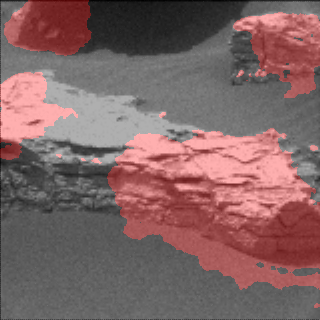

Dice score for class 0: 0.7126867452985891
Dice score for class 1: 0.42147535235925754
Dice score for class 0: 0.7206066585200648
Dice score for class 1: 0.4190884766562199
MPA:  0.5777592
MPA compressed:  0.57763404
Dice:  0.7023744853319636
Dice compressed:  0.7040721526203011
IoU:  0.40297228
IoU compressed:  0.40289915
Rmse:  0.64980054
Rmse compressed:  0.64989686


In [60]:
i = 10
show_results_with_compressed(i, rockA_input_img_paths, rockA_target_img_paths, rockA_preds, rockA_preds_compressed)
(metrics, metrics_compressed) = double_metrics_calculation(rockA_preds, rockA_preds_compressed, rockA_target_img_paths, 1)

print('MPA: ', metrics[0][i])
print('MPA compressed: ', metrics_compressed[0][i])

print('Dice: ', metrics[1][i])
print('Dice compressed: ', metrics_compressed[1][i])
print('IoU: ', metrics[2][i])
print('IoU compressed: ', metrics_compressed[2][i])
print('Rmse: ', metrics[3][i])
print('Rmse compressed: ', metrics_compressed[3][i])

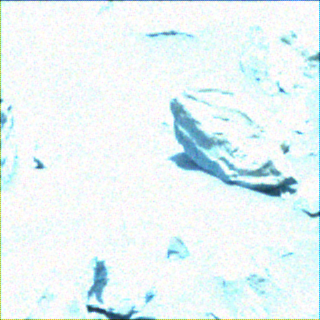

Target: 


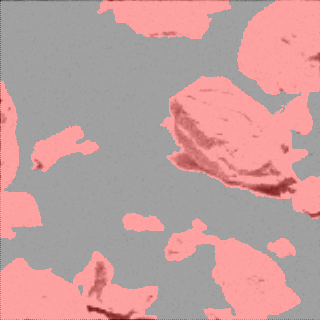

Prediction: 


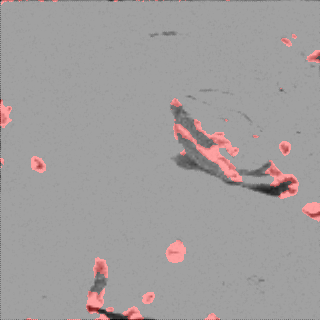

Compressed prediction: 


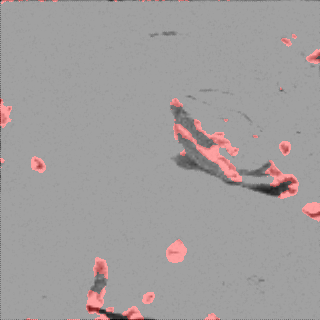

Dice score for class 0: 0.6176245956539312
Dice score for class 1: 0.40435314463486466
Dice score for class 0: 0.6323897443929357
Dice score for class 1: 0.39876468780565744
MPA:  0.72441
MPA compressed:  0.72523504
Dice:  0.46898024905685626
Dice compressed:  0.47146269356332315
IoU:  0.43757686
IoU compressed:  0.43918133
Rmse:  0.52496666
Rmse compressed:  0.52418023


In [61]:
i = 28
show_results_with_compressed(i, rockB_input_img_paths, rockB_target_img_paths, rockB_preds, rockB_preds_compressed)
(metrics, metrics_compressed) = double_metrics_calculation(rockB_preds, rockB_preds_compressed, rockB_target_img_paths, 1)

print('MPA: ', metrics[0][i])
print('MPA compressed: ', metrics_compressed[0][i])

print('Dice: ', metrics[1][i])
print('Dice compressed: ', metrics_compressed[1][i])
print('IoU: ', metrics[2][i])
print('IoU compressed: ', metrics_compressed[2][i])
print('Rmse: ', metrics[3][i])
print('Rmse compressed: ', metrics_compressed[3][i])

In [36]:
def eval_preds(preds, img_paths, metric_name="", color_threshold = 1):
    # Define metrics
    meanIoU = tf.keras.metrics.MeanIoU(num_classes=2)
    accuracy = tf.keras.metrics.Accuracy()
    rmse = tf.keras.metrics.RootMeanSquaredError()

    # Calculate metrics for validation set
    dice_loss = np.mean(calculate_dice_loss(preds, img_paths, color_threshold))
    iou = np.mean(evaluate_model(preds, img_paths, meanIoU, color_threshold))
    accuracy =  np.mean(evaluate_model(preds, img_paths, accuracy, color_threshold))
    rmse = np.mean(evaluate_model(preds, img_paths, rmse, color_threshold))

    metrics = [dice_loss, iou, accuracy, rmse]
    
    # Display metrics
    print("Dice score on {} set: {}".format(metric_name, dice_loss))
    print("Mean IoU on {} set: {}".format(metric_name, iou))
    print("Accuracy on {} set: {}".format(metric_name, accuracy))
    print("RMSE on {} set: {}".format(metric_name,rmse))
    print()

    return metrics

In [37]:
eval_preds(rockA_preds, rockA_target_img_paths, 'rockA')

# eval_preds(rockA_greyscaled_preds, rockA_target_img_paths, 'greyscaled rockA')

eval_preds(rockB_preds, rockB_target_img_paths, 'rockB')

# eval_preds(rockB_greyscaled_preds, rockB_target_img_paths, 'greyscaled rockB')

Dice score for class 0: 0.7126868780902086
Dice score for class 1: 0.4214756836719891
Dice score on rockA set: 0.5670812808810988
Mean IoU on rockA set: 0.4877159595489502
Accuracy on rockA set: 0.6750087738037109
RMSE on rockA set: 0.5678931474685669

Dice score for class 0: 0.6176246666720356
Dice score for class 1: 0.4043531521877794
Dice score on rockB set: 0.5109889094299075
Mean IoU on rockB set: 0.45417356491088867
Accuracy on rockB set: 0.6690980792045593
RMSE on rockB set: 0.5744878649711609



[0.5109889094299075, 0.45417356, 0.6690981, 0.57448786]

In [89]:
def get_all_metrics_as_df(preds, img_paths, color_threshold):
    meanIoU = tf.keras.metrics.MeanIoU(num_classes=2)
    accuracy = tf.keras.metrics.Accuracy()
    rmse = tf.keras.metrics.RootMeanSquaredError()

    dice_loss = calculate_dice_loss(preds, img_paths, color_threshold)
    iou = evaluate_model(preds, img_paths, meanIoU, color_threshold)
    accuracy =  evaluate_model(preds, img_paths, accuracy, color_threshold)
    rmse = evaluate_model(preds, img_paths, rmse, 1)
    
    metrics = [dice_loss, iou, accuracy, rmse]
    metrics = np.array(metrics)
    # metrics = metrics
    # print(metrics.shape)
    return pd.DataFrame(metrics.T, columns=['dice', 'iou', 'mpa', 'rmse'])

model_name = "linknet_mobilenetv2"
df = get_all_metrics_as_df(rockA_preds, rockA_target_img_paths, 1)
df.to_csv("{}_rock-A.csv".format(model_name))

df = get_all_metrics_as_df(rockB_preds, rockB_target_img_paths, 1)
df.to_csv("{}_rock-B.csv".format(model_name))

df = get_all_metrics_as_df(rockA_preds_compressed, rockA_target_img_paths, 1)
df.to_csv("{}_rock-A_compressed.csv".format(model_name))

df = get_all_metrics_as_df(rockB_preds_compressed, rockB_target_img_paths, 1)
df.to_csv("{}_rock-B_compressed.csv".format(model_name))

Dice score for class 0: 0.870849211475468
Dice score for class 1: 0.5876092824268625
Dice score for class 0: 0.8683647434764201
Dice score for class 1: 0.6344088309305843
Dice score for class 0: 0.8724873273995506
Dice score for class 1: 0.5820428538790998
Dice score for class 0: 0.8719700727939278
Dice score for class 1: 0.6210645257123335


Todo: fix greyscaled generator